In [1]:
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from utils import (
    gradient_penalty,
    plot_to_tensorboard,
    save_checkpoint,
    load_checkpoint,
    generate_examples,
    seed_everything
)
from model import Discriminator, Generator
from math import log2
from tqdm import tqdm
import config
import os
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

/home/kworapob/miniconda3/envs/pytorch_py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(config.CHANNELS_IMG)],
                [0.5 for _ in range(config.CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = config.BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root='/mnt/d/ML_playground/DIP_AI-Hack_datagen/IM_Train/train', transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
    )
    return loader, dataset

In [3]:
loader, dataset = get_loader(256)

In [4]:
batch, label = next(iter(loader))

In [5]:
label

tensor([2, 1, 8, 1, 5, 6, 2, 0, 4, 1, 0, 1, 1, 8, 5, 4])

In [6]:
gen = Generator(
        522, 512, img_channels=3
    )

In [7]:
import torch.nn as nn

label_emb = nn.Embedding(10, 10)
label_emb(torch.tensor([1])).unsqueeze(2).unsqueeze(3).shape


torch.Size([1, 10, 1, 1])

In [8]:
noise = torch.randn(1, 512, 1, 1)
gen(noise,torch.tensor([1]),1,1)

torch.Size([1, 522, 1, 1])


tensor([[[[ 0.9872,  0.9014,  0.9137,  ..., -0.8934, -0.7153, -0.9583],
          [ 0.7718,  0.9650,  0.9964,  ...,  0.9606,  0.9812, -0.0244],
          [ 0.8874,  0.9780,  0.9981,  ...,  0.5145,  0.8064, -0.2941],
          ...,
          [ 0.5429,  0.7258,  0.5853,  ..., -0.7243, -0.6009,  0.5369],
          [-0.5106,  0.0303, -0.7063,  ..., -0.5721, -0.8104,  0.5952],
          [ 0.0763,  0.3637, -0.2419,  ..., -0.0302, -0.7166,  0.8068]],

         [[-0.8977, -0.7054, -0.9044,  ..., -0.2764, -0.9465, -0.9534],
          [-0.8415, -0.7579, -0.7134,  ..., -0.9450, -0.8686, -0.9144],
          [-0.8804, -0.9243, -0.9278,  ..., -0.9485, -0.9679, -0.7147],
          ...,
          [-0.9839, -0.9991, -0.9990,  ..., -0.7629, -0.8671, -0.5704],
          [-0.9686, -0.9982, -0.9992,  ..., -0.6618, -0.9802, -0.8186],
          [-0.7122, -0.9922, -0.9744,  ..., -0.3514, -0.9415, -0.0048]],

         [[-0.0120, -0.5781, -0.3875,  ..., -0.0651, -0.7907,  0.5880],
          [-0.9437, -0.8010, -

In [2]:
gen = Generator(
        config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
    ).to(config.DEVICE)
critic = Discriminator(
        config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
    ).to(config.DEVICE)

# initialize optimizers and scalers for FP16 training
opt_gen = optim.Adam(
    gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
scaler_critic = torch.cuda.amp.GradScaler()
scaler_gen = torch.cuda.amp.GradScaler()
print(gen)
print(critic)

Generator(
  (label_emb): Embedding(11, 10)
  (initial): Sequential(
    (0): PixelNorm()
    (1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.2)
    (3): WSConv2d(
      (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (4): LeakyReLU(negative_slope=0.2)
    (5): PixelNorm()
  )
  (initial_rgb): WSConv2d(
    (conv): Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (prog_blocks): ModuleList(
    (0-2): 3 x ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (3): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [3]:
load_checkpoint(
            '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/checkpoint_cleaned-data-secondtry/generator_sz32/generator99_3_1500.pth', gen, opt_gen, config.LEARNING_RATE,
        )
# load_checkpoint(
#             '/mnt/c/Users/Worapob/Desktop/ML_playground/ProGAN/checkpoint/critic_sz128/critic25_5_634.pth', critic, opt_critic, config.LEARNING_RATE,
#         )

=> Loading checkpoint from /home/kworapob/DIP_AI-Hack_datagen/ProGAN/checkpoint_cleaned-data-secondtry/generator_sz32/generator99_3_1500.pth


[1500, 99, 1]

In [4]:
def generate_transition_codes(num_codes, latent_dim, num_steps=10,device='cuda'):

    start_codes = torch.randn(num_codes, latent_dim,device=device)

    end_codes = torch.randn(num_codes, latent_dim,device=device)
    transition_codes = []
    for i in range(num_steps):
        alpha = i / (num_steps - 1)  
        intermediate_codes = (1 - alpha) * start_codes + alpha * end_codes
        transition_codes.append(intermediate_codes)

    return torch.cat(transition_codes)

def show_tensor_test_img(img_tensor,num_imgs=25,nrow=5,size=(5,5),epoch=0):
    img_tensor=(img_tensor+1)/2
    img_unflat = img_tensor.detach().cpu()
    img_unflat = img_unflat.expand(-1, 3, -1, -1)
    img_grid = make_grid(img_unflat[:num_imgs],nrow=nrow)
    plt.figure(figsize=size)
    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.axis('off')
    plt.show()

def generate_gif(img_ls, save_path):
    img_ls=(img_ls+1)/2
    img_ls=img_ls.detach().cpu()
    img_ls=img_ls.expand(-1, 3, -1, -1)
    transform = transforms.ToPILImage()
    images = [transform(img) for img in img_ls]
    
    # Save the images as a GIF
    images[0].save(save_path, save_all=True, append_images=images[1:], optimize=False, duration=1, loop=0)

    return images

torch.Size([10, 502, 1, 1])
torch.Size([10])
torch.Size([10, 3, 32, 32])


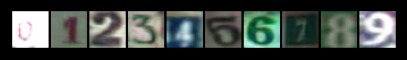

In [31]:
device = "cuda"
step = int(log2(32/ 4))
noise = torch.randn(10, 502, 1, 1).to(device)
print(noise.shape)
img_cls = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)
print(img_cls.shape)
img = gen(noise,img_cls, 1.0, step)
print(img.shape)
show_tensor_test_img(img,num_imgs=10,nrow=10)

In [36]:
manipulate_test_noise = generate_transition_codes(10,512,num_steps=10,device='cuda')
img_cls = torch.tensor([0*100]).to(device)
step = int(log2(128/ 4))
print(manipulate_test_noise.shape)
print(manipulate_test_noise)


img = gen(manipulate_test_noise,img_cls, 1.0, step)
show_tensor_test_img(img,num_imgs=100,nrow = 10,size=(8,8))

torch.Size([100, 512])
tensor([[ 1.6058, -0.7339,  0.2171,  ..., -0.2430, -0.9420,  1.2733],
        [ 0.2472, -1.0793, -0.1682,  ...,  0.3773,  0.6070, -0.3894],
        [ 1.7358, -0.7768,  1.4079,  ...,  0.2335, -0.0392,  0.1956],
        ...,
        [-1.5879,  0.9690, -1.6398,  ..., -0.6171, -0.9470,  1.4326],
        [-0.3537,  2.2684,  2.6491,  ..., -0.2837, -0.3205, -1.1047],
        [ 0.8592, -2.7316,  1.5805,  ..., -0.3947,  1.7677,  0.1595]],
       device='cuda:0')


RuntimeError: Tensors must have same number of dimensions: got 2 and 4